In [1]:
import torch
import os,sys
sys.path.append("..")

In [2]:
# --- Stage-0 : set paths & load raw arrays ----------------------------
from pathlib import Path
import numpy as np

DATA_DIR = Path(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw")          # change here if you move the .npy files

RAW_X_TRAIN = DATA_DIR / "xs_train.npy"
RAW_X_TEST  = DATA_DIR / "xs_test.npy"
RAW_Y_TRAIN = DATA_DIR / "ys_train.npy"
RAW_Y_TEST  = DATA_DIR / "ys_test.npy"

xs_train = np.load(RAW_X_TRAIN)           # (N_train, 192, 2)
xs_test  = np.load(RAW_X_TEST)            # (N_test , 192, 2)
ys_train = np.load(RAW_Y_TRAIN)           # (N_train, 2)  -> [CL, CD]
ys_test  = np.load(RAW_Y_TEST)            # (N_test , 2)

print("Train shapes :", xs_train.shape, ys_train.shape)
print("Test  shapes :", xs_test.shape , ys_test.shape)
# ----------------------------------------------------------------------


Train shapes : (38802, 192, 2) (38802, 2)
Test  shapes : (9701, 192, 2) (9701, 2)


In [15]:
import sys, os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../.."))
sys.path.append("../surrogate_models")
import torch.nn as nn
import torch.nn.functional as F
import torch

activation_function_list = [torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), nn.ELU(), nn.Hardswish(),torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), torch.tanh]
class MultiLayerPerceptron_forward(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, net_n):
        super(MultiLayerPerceptron_forward, self).__init__()
        #################################################################################
        # Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        #################################################################################
        layers = []
        layers.append(nn.Linear((input_size), (hidden_layers[0])))
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear((hidden_layers[i]), (hidden_layers[i+1])))

        layers.append(nn.Linear((hidden_layers[len(hidden_layers)-1]), (num_classes)))
        self.layers = nn.Sequential(*layers)
        self.net_n = net_n
        self.hidden_layers = hidden_layers
    def forward(self, x):
        #################################################################################
        # Implement the forward pass computations                                 #
        #################################################################################
        m = activation_function_list[self.net_n]
        for i in range(len(self.hidden_layers)):
            x = self.layers[i](x)
            x = m(x)
        x = (self.layers[len(self.hidden_layers)](x))
        out=x
        return out
    

import torch
import torch.nn as nn
import torch.nn.functional as F

# List of activation functions
activation_function_list = [
    torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), nn.ELU(),
    nn.Hardswish(), torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), torch.tanh
]

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim

        # Learnable linear projections
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.scale = embed_dim ** 0.5

    def forward(self, x):
        # x shape: (batch, seq_len, embed_dim)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Attention scores: (batch, seq_len, seq_len)
        scores = torch.bmm(Q, K.transpose(1, 2)) / self.scale
        attn_weights = F.softmax(scores, dim=-1)

        # Weighted sum: (batch, seq_len, embed_dim)
        attn_output = torch.bmm(attn_weights, V)
        return attn_output


class MultiLayerPerceptronWithCustomAttention(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, net_n):
        super(MultiLayerPerceptronWithCustomAttention, self).__init__()

        # MLP Layers
        layers = []
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        self.mlp_layers = nn.ModuleList(layers)
        self.activation = activation_function_list[net_n]
        
        self.attention = SelfAttention(embed_dim=hidden_layers[-1])
        self.final_linear = nn.Linear(hidden_layers[-1], num_classes)

    def forward(self, x):
        # MLP forward
        for layer in self.mlp_layers:
            x = self.activation(layer(x))

        # Reshape for attention: treat features as a sequence of length 1
        x = x.unsqueeze(1)  # (batch, 1, embed_dim)

        # Apply attention
        x = self.attention(x)

        # Flatten back to (batch, embed_dim)
        x = x.squeeze(1)

        # Final output
        out = self.final_linear(x)
        return out


In [16]:
model = MultiLayerPerceptron_forward(
    input_size=192 * 2 , hidden_layers= [128,62,32,16] , num_classes=2 , net_n=3
)

In [17]:
out  = model(torch.zeros(1,192*2))
print(f"{out.shape=}")

out.shape=torch.Size([1, 2])


In [18]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



158602
Epoch [1/250] - Train Loss: 0.048508, Test Loss: 0.033252
New best model at epoch 1 with test loss 0.033252
Epoch [2/250] - Train Loss: 0.022967, Test Loss: 0.018249
New best model at epoch 2 with test loss 0.018249
Epoch [3/250] - Train Loss: 0.018760, Test Loss: 0.014924
New best model at epoch 3 with test loss 0.014924
Epoch [4/250] - Train Loss: 0.017464, Test Loss: 0.015299
Epoch [5/250] - Train Loss: 0.016085, Test Loss: 0.017807
Epoch [6/250] - Train Loss: 0.015491, Test Loss: 0.011589
New best model at epoch 6 with test loss 0.011589
Epoch [7/250] - Train Loss: 0.015155, Test Loss: 0.011262
New best model at epoch 7 with test loss 0.011262
Epoch [8/250] - Train Loss: 0.013679, Test Loss: 0.012659
Epoch [9/250] - Train Loss: 0.012939, Test Loss: 0.010568
New best model at epoch 9 with test loss 0.010568
Epoch [10/250] - Train Loss: 0.012044, Test Loss: 0.009163
New best model at epoch 10 with test loss 0.009163
Epoch [11/250] - Train Loss: 0.012853, Test Loss: 0.012710
Ep

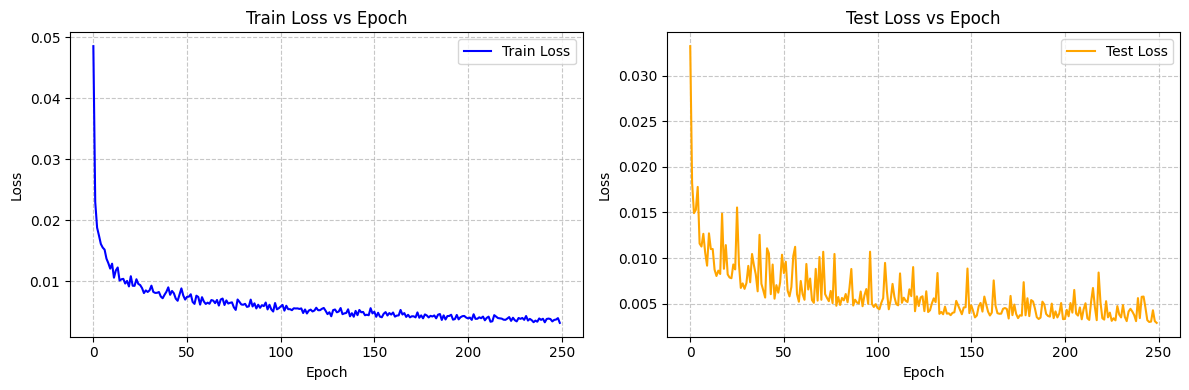

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import scipy.io as sio
import argparse
import numpy as np
import time
import matplotlib.pyplot as  plt


input_size = 192 * 2
hidden_size = [150, 200, 200 , 150]
num_classes = 2
num_epochs = 250
learning_rate = 9e-4
# learning_rate = 5e-6
learning_rate_decay = 0.999
reg = 0.001
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 2
patience = 100

xs_train = np.load(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_train.npy")
ys_train = np.load(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/ys_train.npy")

xs_train = xs_train.reshape(xs_train.shape[0],-1)

x_train_tensor = torch.from_numpy(xs_train).float()
y_train_tensor = torch.from_numpy(ys_train).float()
# print(ys_train[:3])
# sys.exit()

dataset = TensorDataset(x_train_tensor, y_train_tensor)

lengths = [int(len(dataset)*0.9), len(dataset)-int(len(dataset)*0.9)]

train_dataset, val_dataset = torch.utils.data.random_split(dataset, lengths)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size , 
                                           num_workers=  num_workers,
                                           drop_last= True , 
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size , 
                                         num_workers = num_workers)



# model_mlp = MultiLayerPerceptronWithCustomAttention(input_size, hidden_size, num_classes,4).to(device)
model_mlp = MultiLayerPerceptron_forward(input_size, hidden_size, num_classes,3).to(device)
print(count_parameters(model_mlp))

# model_mlp.apply(weights_init)
# model_mlp.load_state_dict(torch.load("/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/mlp_best_model.pt",map_location="cpu"))
model_mlp.to(device)

# Loss and optimizer
def sum_mse(yhat,y):
    return torch.sum(torch.mean((yhat - y) ** 2, dim=1))

criterion_MSE = nn.MSELoss()
criterion_MAE = nn.L1Loss()
criterion_sum_mse = sum_mse



# criterion = criterion_MAE
# criterion_train= sum_mse
# criterion_val   = nn.MSELoss()  # Standard mean MSE
criterion_train= nn.L1Loss()
criterion_val   = nn.L1Loss()  # Standard mean MSE
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)

########################################
# 5) Training loop with early stopping
########################################
best_loss = float('inf')
best_epoch = 0
epochs_no_improve = 0
lr_current = learning_rate

train_losses = []
test_losses  = []

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    # ---- Training ----
    model_mlp.train()
    running_loss = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_mlp(features)  # shape (batch, 2)
        loss = criterion_train(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)

        # if (batch_idx + 1) % 100 == 0:
        #     print(f"Epoch [{epoch}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}],"
        #           f" Train Loss (batch): {loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- Validation ----
    model_mlp.eval()
    test_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            preds = model_mlp(features)
            test_loss += criterion_val(preds, labels).item() * features.size(0)
    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # Print log
    print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}")

    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(model_mlp.state_dict(), "mlp_best_model.pt")
        print(f"New best model at epoch {epoch} with test loss {best_loss:.6f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement for {patience} epochs. Early stopping at epoch {epoch}.")
            break

    # Update learning rate
    lr_current *= learning_rate_decay
    update_lr(optimizer, lr_current)

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed:.2f} seconds. Best epoch: {best_epoch} with test loss {best_loss:.6f}")

# Save final model weights
torch.save(model_mlp.state_dict(), "mlp_final_model.pt")
print("Saved mlp_final_model.pt")


############################################################
# 6) Save and plot train/test losses in separate subplots
############################################################
train_losses = np.array(train_losses)
test_losses  = np.array(test_losses)

# Save them as .npy
np.save("train_losses.npy", train_losses)
np.save("test_losses.npy",  test_losses)

# Two subplots: one for Train Loss, one for Test Loss
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(train_losses, label="Train Loss", color="blue")
axs[0].set_title("Train Loss vs Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True, linestyle="--", alpha=0.7)
axs[0].legend()

axs[1].plot(test_losses, label="Test Loss", color="orange")
axs[1].set_title("Test Loss vs Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].grid(True, linestyle="--", alpha=0.7)
axs[1].legend()

plt.tight_layout()
plt.show()

## Evaluating the surrogate model

In [80]:
def inverse_scale_label_mlp(scaled_label, y_min, y_max):
    """
    scaled_label: shape (2,) or (batch,2) in [0,1]
    y_min, y_max: shape (2,)

    Returns real values: shape matching scaled_label
    """
    # If tensor, convert to NumPy
    if isinstance(scaled_label, torch.Tensor):
        scaled_label = scaled_label.cpu().numpy()

    # Flatten y_min, y_max to (2,) if they aren't already
    y_min = y_min.ravel()
    y_max = y_max.ravel()

    if scaled_label.ndim == 1:
        # shape => (2,)
        return scaled_label * (y_max - y_min) + y_min
    else:
        # shape => (batch,2)
        return scaled_label * (y_max[None,:] - y_min[None,:]) + y_min[None,:]

def visualize_predictions_grid_mlp(model, dataset, y_min, y_max, device,
                                   sample_indices=None, set_name="Train",
                                   figsize=(20,8)):
    """
    Similar to 'visualize_predictions_grid' but adapted for an MLP
    that receives flattened input of shape (384,).

    dataset: a TensorDataset where each sample is (features, label):
      - features.shape == (384,)
      - label.shape == (2,) in [0,1].

    We reshape the flattened input to (192,2)->.T =>(2,192) for plotting.
    We call 'inverse_scale_label_mlp' to get the real (CL, ratio).
    """
    model.eval()

    # If no specific indices given, pick 5 random
    if sample_indices is None:
        num_samples = 5
        sample_indices = np.random.choice(len(dataset), size=num_samples, replace=False)
    else:
        num_samples = len(sample_indices)

    fig, axs = plt.subplots(2, num_samples, figsize=figsize)

    for j, idx in enumerate(sample_indices):
        # 1) Extract features (384,) and label (2,)
        features, scaled_label = dataset[idx]
        print(f"{scaled_label}")

        # Reshape to (192,2) => transpose =>(2,192)
        coords_2d = features.reshape(192,2).T  # row0 => X, row1 => Y
        coords_np = coords_2d.numpy()  # for plotting

        # 2) Model forward pass
        with torch.no_grad():
            features_batch = features.unsqueeze(0).to(device)   # => (1,384)
            pred_scaled = model(features_batch.reshape(features_batch.shape[0],-1))                 # => (1,2)
        pred_scaled = pred_scaled.squeeze(0).cpu().numpy()      # => (2,)
        print(fr"{pred_scaled=}")
        print(fr"{scaled_label=}")
        sys.exit()

        # 3) Inverse-scale ground-truth & predicted
        true_unscaled = inverse_scale_label_mlp(scaled_label, y_min, y_max)
        pred_unscaled = inverse_scale_label_mlp(pred_scaled,   y_min, y_max)

        # For convenience
        true_CL_scaled    = scaled_label[0].item()
        pred_CL_scaled    = pred_scaled[0]
        true_ratio_scaled = scaled_label[1].item()
        pred_ratio_scaled = pred_scaled[1]

        true_CL_real    = true_unscaled[0]
        pred_CL_real    = pred_unscaled[0]
        true_ratio_real = true_unscaled[1]
        pred_ratio_real = pred_unscaled[1]

        # --- Top row: CL info
        axs[0, j].plot(coords_np[0], coords_np[1], 'b-', linewidth=1)
        axs[0, j].set_title(
            f"Sample {idx}\n"
            f"CL (scaled): T={true_CL_scaled:.3f}, P={pred_CL_scaled:.3f}\n"
            f"CL (real):   T={true_CL_real:.3f}, P={pred_CL_real:.3f}"
        )
        axs[0, j].set_xlabel("X")
        axs[0, j].set_ylabel("Y")
        axs[0, j].set_aspect('equal', adjustable='box')
        axs[0, j].grid(True, linestyle="--", alpha=0.6)

        # --- Bottom row: CL/CD ratio info
        axs[1, j].plot(coords_np[0], coords_np[1], 'b-', linewidth=1)
        axs[1, j].set_title(
            f"Ratio (scaled): T={true_ratio_scaled:.3f}, P={pred_ratio_scaled:.3f}\n"
            f"Ratio (real):   T={true_ratio_real:.3f}, P={pred_ratio_real:.3f}"
        )
        axs[1, j].set_xlabel("X")
        axs[1, j].set_ylabel("Y")
        axs[1, j].set_aspect('equal', adjustable='box')
        axs[1, j].grid(True, linestyle="--", alpha=0.6)

    plt.suptitle(f"{set_name} Set Predictions (MLP)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_small_subset_predictions_mlp(model, dataset, y_min, y_max, device,
                                      sample_count=100, set_name="Train"):
    """
    Plots 100 random samples' real vs. predicted CL and ratio in 2 subplots.

    dataset: TensorDataset with shape (384,) for features, (2,) for label.
    We do not need to reshape to (2,192) here, because we only want numeric comparisons.
    """
    model.eval()

    indices = np.random.choice(len(dataset), size=sample_count, replace=False)
    indices = sorted(indices)

    real_CL_vals = []
    real_ratio_vals = []
    pred_CL_vals = []
    pred_ratio_vals = []

    with torch.no_grad():
        for idx in indices:
            features, scaled_label = dataset[idx]
            # Model forward pass
            features_batch = features.unsqueeze(0).to(device)  # (1,384)
            pred_scaled = model(features_batch)                # => (1,2)
            pred_scaled = pred_scaled.squeeze(0).cpu().numpy() # => (2,)

            # Inverse scale
            true_unscaled = inverse_scale_label_mlp(scaled_label, y_min, y_max)
            pred_unscaled = inverse_scale_label_mlp(pred_scaled,   y_min, y_max)

            real_CL_vals.append(true_unscaled[0])
            real_ratio_vals.append(true_unscaled[1])
            pred_CL_vals.append(pred_unscaled[0])
            pred_ratio_vals.append(pred_unscaled[1])

    x_axis = np.arange(sample_count)
    plt.figure(figsize=(12, 8))

    # --- top subplot: CL
    plt.subplot(2, 1, 1)
    plt.plot(x_axis, real_CL_vals, 'o-', label="True CL", color='blue', alpha=0.7)
    plt.plot(x_axis, pred_CL_vals, 's--', label="Pred CL", color='red', alpha=0.7)
    plt.title(f"{set_name} Set: CL on {sample_count} samples")
    plt.xlabel("Sample Index")
    plt.ylabel("CL (real scale)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    # --- bottom subplot: CL/CD ratio
    plt.subplot(2, 1, 2)
    plt.plot(x_axis, real_ratio_vals, 'o-', label="True Ratio", color='blue', alpha=0.7)
    plt.plot(x_axis, pred_ratio_vals, 's--', label="Pred Ratio", color='red', alpha=0.7)
    plt.title(f"{set_name} Set: CL/CD on {sample_count} samples")
    plt.xlabel("Sample Index")
    plt.ylabel("CL/CD (real scale)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

# 1) After finishing training (and optionally reloading your model)...
y_min = np.load(os.path.join(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data", "y_min.npy"))  # shape (1,2)
y_max = np.load(os.path.join(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data", "y_max.npy"))  # shape (1,2)

In [81]:
import os
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class AirfoilDataset(Dataset):
    """
    Loads scaled airfoil coordinates and scaled CL/CD labels,
    and can invert them back to physical units.
    """
    def __init__(self,
                 xs_scaled_path: str,
                 ys_scaled_path: str,
                 coord_min_max_path: str,
                 label_min_max_path: str):
        # load scaled arrays
        self.xs = np.load(xs_scaled_path)   # (N, 192, 2), values in [0,1]
        self.ys = np.load(ys_scaled_path)   # (N, 2), values in [0,1]

        # load min/max for coords & labels
        coord_mm = np.load(coord_min_max_path)  # [[x_min,y_min],[x_max,y_max]]
        label_mm = np.load(label_min_max_path)  # [[cl_min,cd_min],[cl_max,cd_max]]

        self.x_min,  self.y_min  = coord_mm[0]
        self.x_max,  self.y_max  = coord_mm[1]
        self.cl_min, self.cd_min = label_mm[0]
        self.cl_max, self.cd_max = label_mm[1]

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx: int):
        # scaled coords: (192,2) -> transpose to (2,192)
        coords = self.xs[idx].T.astype(np.float32)
        cl, cd = self.ys[idx].astype(np.float32)
        return torch.from_numpy(coords), torch.tensor([cl, cd], dtype=torch.float32)

    def inverse_scale_coords(self, coords_scaled: np.ndarray) -> np.ndarray:
        """
        coords_scaled: np array shape (..., 2)
        returns coords in original physical units
        """
        x_s, y_s = coords_scaled[...,0], coords_scaled[...,1]
        x = x_s * (self.x_max - self.x_min) + self.x_min
        y = y_s * (self.y_max - self.y_min) + self.y_min
        return np.stack([x, y], axis=-1)

    def inverse_scale_labels(self, ys_scaled: np.ndarray) -> np.ndarray:
        """
        ys_scaled: shape (N,2)
        returns labels in original (CL, CD) units
        """
        cl_s, cd_s = ys_scaled[:,0], ys_scaled[:,1]
        cl = cl_s * (self.cl_max - self.cl_min) + self.cl_min
        cd = cd_s * (self.cd_max - self.cd_min) + self.cd_min
        return np.stack([cl, cd], axis=-1)

    def plot_sample(self, idx: int = None):
        """
        Shows scaled vs real airfoil and label for one index.
        """
        if idx is None:
            idx = np.random.randint(len(self))
        coords_s, lbl_s = self[idx]
        # back to numpy
        coords_s = coords_s.numpy().T        # (192,2)
        lbl_s    = lbl_s.numpy()[None,:]     # (1,2)
        coords_r = self.inverse_scale_coords(coords_s[None])[0]
        lbl_r    = self.inverse_scale_labels(lbl_s)[0]

        # plot curves
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].plot(coords_s[:,0], coords_s[:,1], label="scaled")
        ax[0].plot(coords_r[:,0], coords_r[:,1], linestyle='--', label="real")
        ax[0].set_aspect('equal')
        ax[0].set_title(f"Airfoil #{idx}")
        ax[0].legend()

        # plot labels
        cl_s_val, cd_s_val = lbl_s[0]
        cl_r_val, cd_r_val = lbl_r
        ax[1].bar(["CL","CD"], [cl_s_val, cd_s_val], alpha=0.7, label="scaled")
        ax[1].bar(["CL","CD"], [cl_r_val, cd_r_val], alpha=0.5, label="real")
        ax[1].set_title("Labels")
        ax[1].legend()

        plt.tight_layout()
        plt.show()


tensor([0.8401, 0.0060])
pred_scaled=array([-22.480978,  -1.978705], dtype=float32)
scaled_label=tensor([0.8401, 0.0060])


SystemExit: 

/home/bardiya/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


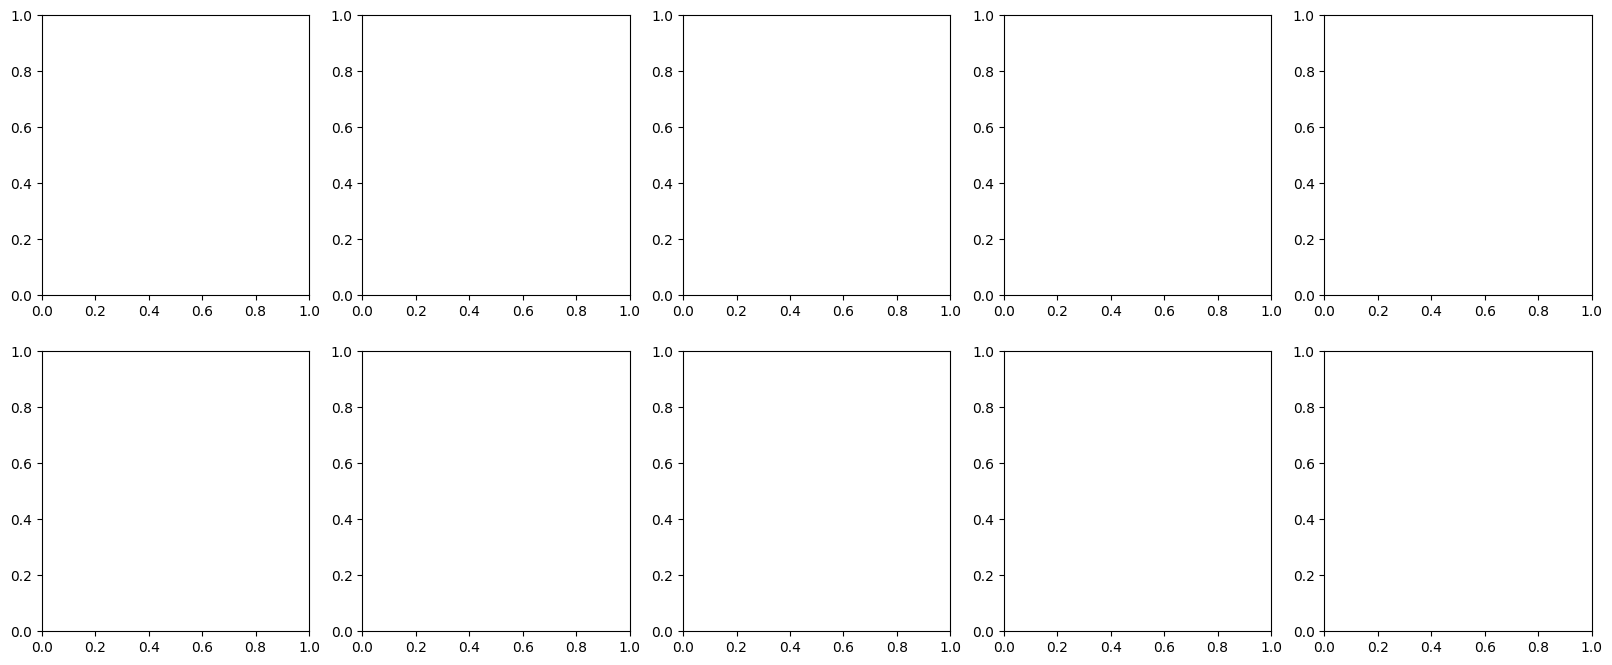

In [82]:
xs_train_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_train.npy"
xs_test_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_test.npy"
ys_train_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/ys_train.npy"
ys_test_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/ys_test.npy"
coord_min_max_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/coord_min_max.npy"
label_min_max_path =  rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/label_min_max.npy"
train_dataset = AirfoilDataset(xs_train_path, ys_train_path, coord_min_max_path, label_min_max_path)
visualize_predictions_grid_mlp(model_mlp , train_dataset ,y_min, y_max,"cuda",set_name="Train")
plot_small_subset_predictions_mlp(model_mlp , train_dataset ,y_min, y_max,"cuda",sample_count=100, set_name="Train")

In [26]:
model_mlp.load_state_dict(torch.load("/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/mlp_best_model.pt",map_location="cpu"))
model_mlp.to(device)
model_mlp.eval()
with torch.no_grad():
    x_train_tensor.shape     
    print(y_train_tensor[2])
    print(model_mlp(x_train_tensor[2].unsqueeze(0).to("cuda")))

tensor([0.4662, 0.0076])
tensor([[0.4611, 0.0067]], device='cuda:0')


/tmp/ipykernel_87119/1204636973.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mlp.load_state_dict(torch.load("/home/bardiya/projects/diffusion_air_manifolding/co